In [1]:
import jax

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_disable_jit", False)

from pathlib import Path
from time import time
import matplotlib.pyplot as plt
import numpy as np
import equinox as eqx
from optax.tree_utils import tree_scale
import jax.numpy as jnp

from jaxmat.loader import ImposedLoading, global_solve
from jaxmat.tensors import SymmetricTensor2
import jaxmat.materials as jm


current_path = Path().resolve()


# @eqx.filter_jit
# def compute_elastoplasticity(material, loading, state):
#     Eps = state.strain

#     eps_dot = 8e-2
#     imposed_eps = 0

#     Nsteps = 21
#     # times = jnp.concatenate((jnp.linspace(0, 0.04, 11), jnp.linspace(0.04, 1.0, Nsteps)[1:]))
#     times = jnp.linspace(0, 0.04, 20)
#     t = 0
#     results = jnp.zeros((len(times), 2))
#     for i, dt in enumerate(jnp.diff(times)):
#         t += dt
#         imposed_eps += eps_dot * dt

#         # FIXME: need to start with non zero Eps
#         def setxx(Eps):
#             return SymmetricTensor2(tensor=Eps.tensor.at[0, 0].set(imposed_eps))

#         Eps = setxx(Eps)
#         loading = eqx.tree_at(
#             lambda l: l.eps_vals, loading, replace_fn=lambda x: x.at[0].set(imposed_eps)
#         )

#         Eps, state, _ = global_solve(Eps, state, loading, material, dt, in_axes=None)
#         # print(state.stress)

#         sig = state.stress
#         p = state.internal.p
#         results = results.at[i + 1, :].set(jnp.array([p, sig[0, 0]]))
#     return results
# @eqx.filter_jit
def compute_elastoplasticity(material, loading, state):
    Eps = state.strain
    eps_dot = 8e-2
    imposed_eps0 = 0.0

    Nsteps_p = 20
    times = jnp.concatenate((jnp.linspace(0, 0.04, 11), jnp.linspace(0.04, 1.0, Nsteps_p)[1:]))
    dts = jnp.diff(times)
    Nsteps = dts.shape[0] + 1

    results_init = jnp.zeros((Nsteps, 2))

    def step_fn(carry, dt):
        imposed_eps, t, Eps, state, results, i = carry

        t = t + dt
        imposed_eps = imposed_eps + eps_dot * dt

        # Update Eps[0, 0]
        # new_tensor = Eps.tensor.at[0, 0].set(imposed_eps)
        # new_tensor = new_tensor.at[1, 1].set(-imposed_eps/2)
        # new_tensor = new_tensor.at[2, 2].set(-imposed_eps/2)
        # new_tensor = jnp.diag(jnp.array([imposed_eps, -imposed_eps/2, -imposed_eps/2]))
        # Eps = SymmetricTensor2(tensor=new_tensor)

        # Sig, state = material.constitutive_update(Eps, state, dt)

        # Update loading.eps_vals[0]
        loading_updated = eqx.tree_at(
            lambda l: l.eps_vals, loading,
            replace_fn=lambda x: x.at[0].set(imposed_eps)
        )

        Eps, state, _ = global_solve(Eps, state, loading_updated, material, dt, in_axes=None)

        sig = state.stress
        p = state.internal.p
        results = results.at[i + 1].set(jnp.array([p, sig[0, 0]]))

        return (imposed_eps, t, Eps, state, results, i + 1), None

    carry_init = (imposed_eps0, 0.0, Eps, state, results_init, 0)

    (imposed_eps, t, Eps, state, results_final, _), _ = jax.lax.scan(step_fn, carry_init, dts)

    return results_final

E, nu = 200e3, 0.3
elastic_model = jm.LinearElasticIsotropic(E, nu)


class YieldStress(eqx.Module):
    sig0: float = eqx.field(converter=jnp.asarray)
    sigu: float = eqx.field(converter=jnp.asarray)
    b: float = eqx.field(converter=jnp.asarray)

    def __call__(self, p):
        return self.sig0 + (self.sigu - self.sig0) * (1 - jnp.exp(-self.b * p))


class YieldStress2(eqx.Module):
    sig0: float = eqx.field(converter=jnp.asarray)
    dsigu: jax.Array
    b: jax.Array
    scale: float = eqx.field(static=True)

    def __call__(self, p):
        return self.scale*self.sig0 + jnp.sum(self.scale*self.dsigu * (1 - jnp.exp(-self.scale*self.b * p)))
    
data = np.loadtxt(current_path / "X100.csv", skiprows=1, delimiter=",")

def interpolate_data(epsp):
    return jnp.interp(epsp, data[:, 0], data[:, 1])


# ys =  YieldStress(sig0=450.0, sigu=900.0, b=100.0)
# ys = YieldStress2(sig0=5.0, dsigu=jnp.asarray([4.5,2.0,0.0]), b=jnp.asarray([1.0, 0.1, 10.0]), scale=100.0)
ys = YieldStress2(sig0=5.0, dsigu=jnp.asarray([4.5]), b=jnp.asarray([1.0]), scale=100.0)
material = jm.vonMisesIsotropicHardening(elastic_model, ys)

material = jax.tree.map(lambda x: jnp.asarray(x, dtype=jnp.float64), material) # force strong type for optax

loading = ImposedLoading(epsxx=0.0)
# state = material.get_state()

# results = compute_elastoplasticity(material, loading, state)

# def eval_loss(results, data):
#     epsp = results[:, 0]
#     sig = results[:, 1]
#     data_interp = interpolate_data(epsp)
#     return jnp.mean(jnp.square(sig - data_interp))

# def compute_loss(material, loading, state):
#     results = compute_elastoplasticity(material, loading, state)
#     loss = eval_loss(results,data)
#     return loss, results

# loss_grad = jax.grad(compute_loss, argnums=0, has_aux=True)

# dloss, results = loss_grad(material, loading, state)

In [2]:
# from timeit import timeit
# duration = timeit(lambda: compute_elastoplasticity(material, loading, state),number=1)
# print("Compilation time", duration)
# duration = timeit(lambda: compute_elastoplasticity(material, loading, state),number=1)
# print("Execution time", duration)

(0.0, 0.03)

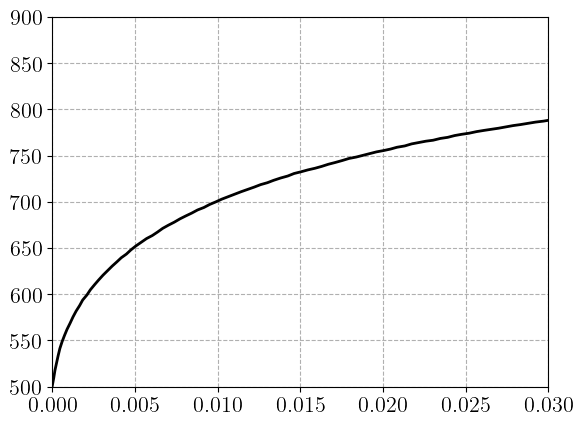

In [3]:
def plot_results(ax, results):
    epsp = results[:, 0]
    sig = results[:, 1]
    ax.plot(epsp, sig, "-", alpha=0.5)

fig, ax = plt.subplots()
ax.plot(data[:, 0], data[:, 1], "-k")
# plot_results(ax, results)
ax.set_xlim(0, 3e-2)

In [4]:


key = jax.random.PRNGKey(42)

N = 6
ys = YieldStress2(sig0=4.0, dsigu=jax.random.lognormal(key, shape=(N,)), b=jax.random.lognormal(key, shape=(N,)), scale=100.0)
material = jm.vonMisesIsotropicHardening(elastic_model, ys)

material = jax.tree.map(lambda x: jnp.asarray(x, dtype=jnp.float64), material) # force strong type for optax


In [5]:
import optimistix as optx
import lineax as lx

solver = optx.LevenbergMarquardt(rtol=1e-4, atol=1e-4, linear_solver=lx.AutoLinearSolver(well_posed=False), verbose=frozenset({"loss", "step_size"}))

@eqx.filter_jit
def loss(material, args):
    loading, state = args
    # material = jax.tree.map(lambda x: jnp.maximum(0, x), material)
    results = compute_elastoplasticity(material, loading, state)
    epsp = results[:, 0]
    sig = results[:, 1]
    data_interp = interpolate_data(epsp)
    return (sig-data_interp)/jnp.max(data_interp), results

# loss_grad = jax.jacrev(loss, argnums=0, has_aux=True)


new_material = tree_scale(1.0, material)
state=material.init_state()
# dloss, results = loss_grad(new_material, (loading, state))
# print(dloss.elastic_model.E)
# print(dloss.elastic_model.nu)
# print(dloss.yield_stress.b)
# print(dloss.yield_stress.sig0)
# print(dloss.yield_stress.dsigu)
# print(dloss.yield_stress.b)
# # (loss, results), dloss = loss_grad(new_material, (loading, state))

In [6]:
# epsp = results[:, 0]
# sig = results[:, 1]
# data_interp = interpolate_data(epsp)
# (sig-data_interp)/jnp.linalg.norm(data_interp,ord=jnp.inf)

In [7]:
sol = optx.least_squares(loss, solver, new_material, args=(loading, state), has_aux=True, throw=False, max_steps=200, options={"jac": "bwd"})

Loss on this step: 1.4151063486179947, Step size: 1.0
Loss on this step: 0.7397076599431058, Step size: 3.5
Loss on this step: 0.586406285252702, Step size: 12.25
Loss on this step: 0.5551129916726617, Step size: 12.25
Loss on this step: 0.5454903269852338, Step size: 12.25
Loss on this step: 0.5417133319995435, Step size: 42.875
Loss on this step: 0.5351440620005304, Step size: 150.0625
Loss on this step: 0.5338988472137041, Step size: 150.0625
Loss on this step: 0.5298280824938675, Step size: 150.0625
Loss on this step: 0.5298149143833668, Step size: 150.0625
Loss on this step: 0.5289966274531984, Step size: 150.0625
Loss on this step: 0.5287110742702134, Step size: 150.0625
Loss on this step: 0.5285793008961971, Step size: 150.0625
Loss on this step: 0.5285377897157594, Step size: 150.0625
Loss on this step: 0.5285145274838404, Step size: 525.21875
Loss on this step: 0.5284724823164761, Step size: 1838.265625
Loss on this step: 0.5284269581346093, Step size: 1838.265625
Loss on this

(0.0, 0.08)

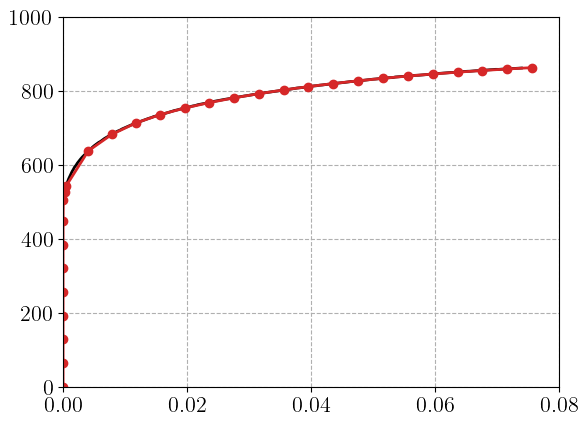

In [8]:
results = sol.aux

fig, ax = plt.subplots()
ax.plot(data[:, 0], data[:, 1], "-k")
epsp = results[:, 0]
sig = results[:, 1]
ax.plot(epsp, sig, "-oC3",)
ax.set_xlim(0, 8e-2)

In [9]:
sol.value.plastic_surface.tol

1e-08